# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 1: Healthcare Resource Allocation Modelling

Modelling a queuing system to model arriving patients (walk ins and prearranged appointments) and the allocation of four clinicians. We want to assess the efficiency of the system and identify causes of delays.


### Modelling Assumptions

- a patient with an appointment arrives every 30 minutes

In [1]:
# Python Packages
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Class defintions
class HealthCareService_c:
    def __init__(self, env, num_clinicians):
        self.env = env
        self.clinicians = simpy.Resource(self.env, num_clinicians)
        self.patients_list = [] # empty list to be filled with Patient_c class objects
        self.num_patients = 0 # initialised as 0
        self.num_in_sys = [(0,0)]
    
    def define_param(self, mu_walkin, mu_service, duration):
        self.mu_walkin = mu_walkin #  mean walkin rate (mins)
        self.mu_service = mu_service # mean service rate (mins)
        self.duration = duration # simulation duration (mins)


class Patient_c:
    def __init__(self, id, type, entry_time):
        self.id = id
        self.type = type
        self.entry_time = entry_time
        self.wait_time = 0
        self.service_time = 0
        self.exit_time = 9999 # arbitrary high number. Gets updated when patient exits
    
    def __str__(self):
        return f"Patient:{self.id}(Type:{self.type}, Entry Time: {self.entry_time}, Exit Time: {self.entry_time})"
    

In [ ]:
# Simulation Functions

def Source_appt():
    # regular appointments through out the day
    # they arrive every 30 mins
    # a pretty hellish schedule lol
    return 30


def Source_walkin(mu_walkin):
    # random walkins
    return np.random.exponential(mu_walkin)

def Service_time(mu_service):
    # how long each appmnt takes
    return np.random.exponential(mu_service)

# Simulation function for the queuing system
def HealthCareService(env, HCS_obj):
    next_patient_time = 0                                       # Intialise time variable to be minimised when the next patient time is determined
    last_patient_type = 1                                       # patient type: 1 = appointment, 2 = walkin
    next_walkin = 0

    mu_walkin = HCS_obj.mu_walkin
    while True:                                                 # In this case, while the simulation is running
        
        # vary patient arrival rate depending on simulation time
        if (env.now>=180 and env.now<=300):
            HCS_obj.mu_walkin = mu_walkin/2 # time in between arrivals is halved


        # Find out which is the next patient: walk in or appointment
        if (next_walkin==0 or last_patient_type == 2):
            # if this value is 0 (initialise) or the last patient was a walkin
            # generate a new talk in time
            next_walkin = Source_walkin(HCS_obj.mu_walkin)
        
        # compare which is the next customer: appointment or walkin
        if (next_walkin < Source_appt()):
            last_patient_type = 2
            next_patient_time = next_walkin
        else:
            last_patient_type = 1
            next_patient_time = Source_appt()
        
        # creating a object in the Patient_c class and appending to patient list
        HCS_obj.num_patients += 1
        Patient_i = Patient_c(HCS_obj.num_patients,last_patient_type,0)
        
        # this is essentially a delay simulation until next customer arrival
        yield env.timeout(next_patient_time)

        # When the customer arrives, start a new customer process
        env.process(Patient(env, HCS_obj, Patient_i))

        # append serviced patient to patient list (all info stored within)
        HCS_obj.patients_list.insert(-1,Patient_i)

# Customer process function to simulate each customer's interaction with the server
def Patient(env, HCS_obj, patient_obj):
    # Request a server from the pool of available servers
    with HCS_obj.clinicians.request() as request:
        # t_arrival = env.now  # Capture the arrival time of the customer
        patient_obj.entry_time = env.now

        # Track the number of customers currently in the system (both in service and in queue)
        HCS_obj.num_in_sys.append((patient_obj.entry_time, len(HCS_obj.clinicians.queue) + len(HCS_obj.clinicians.users)))
        # Log the customer arrival, including the number of customers 
        # print(f'{env.now}: customer {customer} arrives.  Current number of people in the system: {len(servers.queue) + len(servers.users)}')       

        # Yield until the customer gets service (i.e., waits for a server to be available)
        yield request
        ##print(f'{env.now}: customer {customer} is being served')

        # Generate and wait for the service time (time spent being served)
        patient_obj.service_time = Service_time(HCS_obj.mu_service)
        yield env.timeout(patient_obj.service_time)

        # Customer departs after service
        patient_obj.exit_time = env.now  # Capture the departure time of the customer

        # Track the number of customers in the system after this customer departs
        HCS_obj.num_in_sys.append((patient_obj.exit_time, len(HCS_obj.clinicians.queue) + len(HCS_obj.clinicians.users)))

        # Log the customer departure, including the number of customers
        #print(f'{env.now}: customer {customer} departs. Current number of people in the system: {len(servers.queue) + len(servers.users) - 1}')

        # Record the wait time and service time for the customer
        patient_obj.wait_time = patient_obj.exit_time - patient_obj.service_time - patient_obj.entry_time




In [4]:
# Create the simulation environment and server
env = simpy.Environment()
# clinicians = simpy.Resource(env, capacity=4)  # initialise the servers

# Create HealthCareService_c class object
HealthCareSim = HealthCareService_c(env, 4)

# Initialise model parameters
HealthCareSim.define_param(mu_walkin=5, mu_service=20,duration=1000)

# Start the simulation
HealthCareSim.env.process(HealthCareService(HealthCareSim.env, HealthCareSim))
# Run the simulation for a given time 
HealthCareSim.env.run(until=HealthCareSim.duration)

# Create parameter sweep
n_intvl = 15
arrival_rates = np.linspace(5,30,n_intvl)
service_rates = np.linspace(5,30,n_intvl)
sim_duration = 60*8
simulation_list = []
# print(arrival_rates)

avg_service = np.zeros([n_intvl,n_intvl])
avg_wait = np.zeros([n_intvl,n_intvl])
max_wait = np.zeros([n_intvl,n_intvl])

# loop to create simulation class objects
for i in range(n_intvl):
    for j in range(n_intvl):
        env = simpy.Environment()
        #initialise simulation class object
        HealthCareSim = HealthCareService_c(env, 4)
        HealthCareSim.define_param(mu_walkin=arrival_rates[i], mu_service=service_rates[j],duration=sim_duration)
        #run simulation
        env.process(HealthCareService(HealthCareSim.env, HealthCareSim))
        env.run(until=HealthCareSim.duration)
        # extract wait times and service times
        patient_waits = [patient.wait_time for patient in HealthCareSim.patients_list]
        patient_service = [patient.service_time for patient in HealthCareSim.patients_list]
        # calculate averages
        avg_wait[i,j] = np.mean(patient_waits)
        max_wait[i,j] = np.max(patient_waits)
        avg_service[i,j] = np.mean(patient_service)

# print(avg_wait)
# print(avg_service)
    



KeyboardInterrupt: 

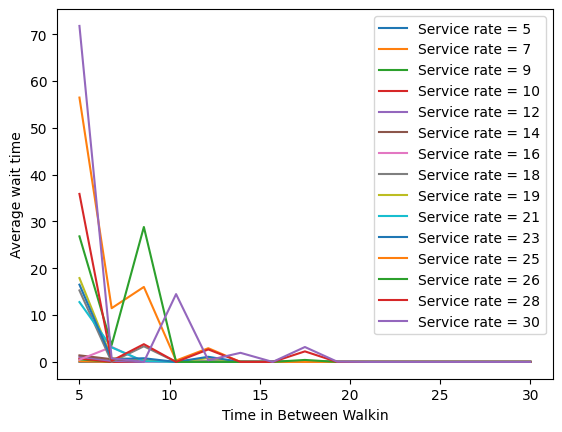

In [ ]:
legend_labels = []
for i in range(n_intvl):
    plt.plot(arrival_rates,avg_wait[:,i])  # Plot the times of events (arrivals and departures) vs the number of customers at those times. 

    # create legend
    legend_labels.append(f"Service rate = {round(service_rates[i])}")

# plt.title("")                        # Set the title of the plot
plt.xlabel("Time in Between Walkin")                              # Label the x-axis as 'Time'
plt.ylabel("Average wait time")        # Label the y-axis as 'Number of Customers in System'
plt.legend(legend_labels)
plt.show()                                      # Display the plot

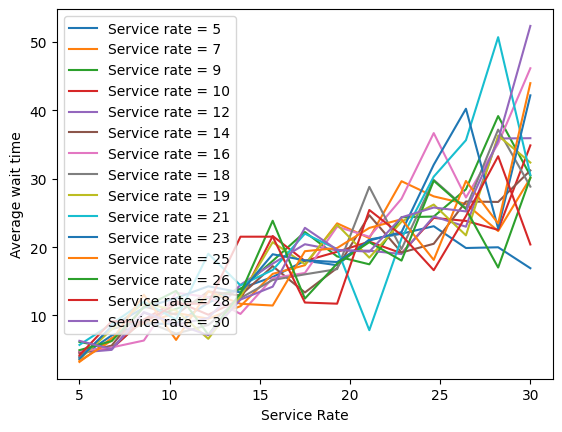

In [ ]:
legend_labels = []
for i in range(n_intvl):
    plt.plot(service_rates,avg_service[i,:])  # Plot the times of events (arrivals and departures) vs the number of customers at those times. 

    # create legend
    legend_labels.append(f"Service rate = {round(service_rates[i])}")

# plt.title("")                        # Set the title of the plot
plt.xlabel("Service Rate")                              # Label the x-axis as 'Time'
plt.ylabel("Average wait time")        # Label the y-axis as 'Number of Customers in System'
plt.legend(legend_labels)
plt.show()

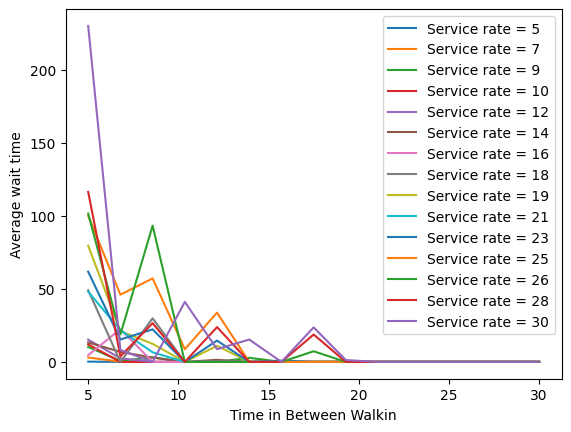

In [ ]:
legend_labels = []
for i in range(n_intvl):
    plt.plot(arrival_rates,max_wait[:,i])  # Plot the times of events (arrivals and departures) vs the number of customers at those times. 

    # create legend
    legend_labels.append(f"Service rate = {round(service_rates[i])}")

# plt.title("")                        # Set the title of the plot
plt.xlabel("Time in Between Walkin")                              # Label the x-axis as 'Time'
plt.ylabel("Average wait time")        # Label the y-axis as 'Number of Customers in System'
plt.legend(legend_labels)
plt.show()                                      # Display the plot